# Business Understanding

## Background and Context

The used car market is highly competitive, and vehicle prices depend on a variety of factors such as age, mileage, fuel type, transmission, and ownership history. Understanding how these factors influence the selling price of a used car can help sellers price their vehicles appropriately and assist buyers in evaluating whether a listed price is reasonable.
The dataset used in this project contains information about used cars collected from the CarDekho platform, including technical specifications and historical selling prices.

## Business Objective

The primary objective of this analysis is to identify and quantify the factors that influence the selling price of used cars. The goal is not only to predict prices accurately, but also to understand the relationship between vehicle characteristics and price in an interpretable manner.

## Data Science Objective

From a data science perspective, the objective is to build an interpretable regression model that explains the variation in used car selling prices using vehicle attributes such as year of manufacture, kilometers driven, fuel type, transmission, and ownership status.

## Success Criteria

The project will be considered successful if:
- Key variables that significantly affect car prices are identified
- The direction and magnitude of each variable’s effect can be clearly interpreted
- The regression assumptions are reasonably satisfied
- The results can be explained in non-technical terms

## Scope and Constraints

The analysis is limited to the variables provided in the dataset  
External economic factors (inflation, location, demand shifts) are not considered  
The focus is on explanation and inference, rather than maximizing predictive accuracy  

## Analytical Approach

The project will follow the CRISP-DM framework, beginning with business understanding and data understanding, followed by data preparation, modeling using linear regression, model evaluation, and interpretation of results.

### Import Required Libraries

In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler

## Data Understanding

### Data Collection

The dataset was obtained from Kaggle and originates from the CarDekho website, a platform for buying and selling used cars.  
Each row in the dataset represents a single used car, along with its characteristics and selling price at the time of listing.  

The data was loaded into the environment using:

In [360]:
df = pd.read_csv('car data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [361]:
df.shape

(301, 9)

The dataset consists of 301 rows and 9 columns and appears to represent real-world data. However, the number of samples is relatively small, so this limitation should be carefully considered when interpreting the results of this project. For example, the regression model may not produce fully reliable results because the dataset does not capture sufficient variation or a wide range of real-world conditions.


### Target Variable
#### Selling_Price(continues, numeric)
The price at which the car was sold(in local currency)

### Predictor Variables

The predictors describe physical, usage-related, and categorical properties of each car:

1. Year: (numeric, discrete): Year the car was manufactured
2. Present_Price: (numeric, continuous): Current market price of the car
3. Kms_Driven: (numeric, continuous): Total distance driven
4. Fuel_Type: (categorical): Petrol / Diesel / CNG
5. Seller_Type: (categorical): Dealer or Individual
6. Transmission: (categorical): Manual or Automatic
7. Owner: (numeric, discrete): Number of previous owners

Although some variables are numeric, they represent counts or categories (e.g., Owner), which must be treated carefully during modeling.

In [362]:
df.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')

In [363]:
df.dtypes

Car_Name          object
Year               int64
Selling_Price    float64
Present_Price    float64
Kms_Driven         int64
Fuel_Type         object
Seller_Type       object
Transmission      object
Owner              int64
dtype: object

##### Columns or features whose data type is stored as object are categorical, based on this there are 3 categorical features in our dataset.

#### Statistical Summary

##### Numeric Variables

In [364]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,301.0,2013.627907,2.891554,2003.00,2012.0,2014.0,2016.0,2018.0
Selling_Price,301.0,4.661296,5.082812,0.10,0.9,3.6,6.0,35.0
Present_Price,301.0,7.628472,8.644115,0.32,1.2,6.4,9.9,92.6
Kms_Driven,301.0,36947.205980,38886.883882,500.00,15000.0,32000.0,48767.0,500000.0
Owner,301.0,0.043189,0.247915,0.00,0.0,0.0,0.0,3.0


##### Categorical Variables

In [365]:
df.describe(include='object').T

,count,unique,top,freq
Car_Name,301,98,city,26
Fuel_Type,301,3,Petrol,239
Seller_Type,301,2,Dealer,195
Transmission,301,2,Manual,261


#### Report

As shown above, the dataset contains a larger number of samples for the petrol fuel type. Since the underlying distribution of the other Fuel_Type categories is not well understood, an alternative method can be employed to further examine their distribution.

In [366]:
df['Fuel_Type'].value_counts()

Fuel_Type
Petrol    239
Diesel     60
CNG         2
Name: count, dtype: int64

As shown above, the number of samples in the CNG category is relatively small, while the diesel category contains more samples, and petrol accounts for the majority of the data. Consequently, the prediction model may not learn the patterns associated with CNG effectively and may also exhibit reduced performance for diesel compared to petrol.

### Interpretation

The numeric variables that describe method gives information about, show evidence of skewness and outliers, particularly for Selling_Price, Present_price and 
Kms_Driven. The majority of cars are relatively recent and have moderate mileage, while a small number of observations correspond to very expensive or heavily used vehicles.

## EDA 

### Data Quality Check

##### Check Missing Values

In [367]:
df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

An inspection of missing values showed that the dataset does not contain null entries, indicating that no imputation was required.

#### Check Outliers

Several variables, particularly Selling_Price and Kms_Driven, exhibit extreme values. These outliers are likely representative of real-world conditions, such as luxury vehicles with high prices or cars with exceptionally high mileage, rather than data collection errors.
<br><br>
To systematically identify these extreme observations, the Interquartile Range (IQR) method was implemented. This method flags values that fall below 
𝑄1−1.5×𝐼𝑄𝑅 or above 𝑄3+1.5×𝐼𝑄𝑅
<br><br>
While the IQR method allows for the identification (and optional removal) of outliers, no outliers were removed at this stage, as they contain meaningful information relevant to the pricing of used cars.

In [368]:
def iqr_outliers(df, column, remove=False):
    """
    Detects outliers in a given column using the IQR method.

    Parameters:
    - df (pd.DataFrame): Input dataframe
    - column (str): Column name to analyze
    - remove (bool): If true, returns dataframe without outliers.

    Returns:
    - outliers (pd.DataFrame): rows identified as outliers(if remove=False)
    - cleaned_df (pd.DataFrame): dataframe without outliers(if remove=True)    
    """

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    if remove:
        cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        return cleaned_df
    
    return outliers

In [369]:
# Detect Outliers
outliers = iqr_outliers(df, 'Selling_Price')
outliers

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
50,fortuner,2012,14.90,30.61,104707,Diesel,Dealer,Automatic,0
51,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0
52,innova,2017,18.00,19.77,15000,Diesel,Dealer,Automatic,0
53,fortuner,2013,16.00,30.61,135000,Diesel,Individual,Automatic,0
59,fortuner,2014,19.99,35.96,41000,Diesel,Dealer,Automatic,0
62,fortuner,2014,18.75,35.96,78000,Diesel,Dealer,Automatic,0
63,fortuner,2015,23.50,35.96,47000,Diesel,Dealer,Automatic,0
64,fortuner,2017,33.00,36.23,6000,Diesel,Dealer,Automatic,0
66,innova,2017,19.75,23.15,11000,Petrol,Dealer,Automatic,0
69,corolla altis,2016,14.25,20.91,12000,Petrol,Dealer,Manual,0


In [370]:
#df_cleaned = iqr_outliers(df, "Selling_Price", remove=True)
#df_cleaned

In [371]:
def outlier_summary_iqr(df, column):
    total_rows = len(df)

    outliers = iqr_outliers(df, column)
    num_of_outliers = len(outliers)
    percentage = (num_of_outliers / total_rows) * 100

    return {
        'Variable': column,
        'Number of Outliers': num_of_outliers,
        '% of Data': round(percentage, 2)
    }

In [372]:
numeric_vars = ['Selling_Price', 'Present_Price', 'Kms_Driven']
summary = []

for variable in numeric_vars:
    summary.append(outlier_summary_iqr(df, variable))

outlier_summary_df = pd.DataFrame(summary)
outlier_summary_df

,Variable,Number of Outliers,% of Data
0,Selling_Price,17,5.65
1,Present_Price,14,4.65
2,Kms_Driven,8,2.66


#### Outlier Analysis
The Interquartile Range(IQR) method was used to identify potential outliers in numerical variables. The table above summarizes the number and proportion of outliers detected in each variable.
<br>
Although several extreme variables were identified, particularly in Selling_Price and Kms_Driven, those observations likely reflect genuin market condition such as luxury vehicles or heavily used cars rather than data errors. Therefore outliers were retained to preserve the real-world variability of the dataset and avoid biasing the model toward average cases only.

In [373]:
# numeric_cols = ['Selling_Price', 'Present_Price', 'Kms_Driven']

# outlier_summary = []

# total_rows = len(df)

# for col in numeric_cols:
#     outliers = iqr_outliers(df, col)
#     n_outliers = len(outliers)
#     percent = (n_outliers / total_rows) * 100

#     outlier_summary.append({
#         'Variable': col,
#         '# Outliers': n_outliers,
#         '% of Data': round(percent, 2)
#     })

# outlier_summary_df = pd.DataFrame(outlier_summary)
# outlier_summary_df


#### Univariate Analysis

In [374]:
# Approach One
def box_hist_plot(variable):
    fig, axes = subplots(1, 2, figsize=(14, 4))
    sns.boxplot(x=df[variable], ax=axes[0]);
    sns.histplot(x=df[variable], ax=axes[1]);
    plt.show()

##### Numerical Variables

In [375]:
numeric_vars = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Year']

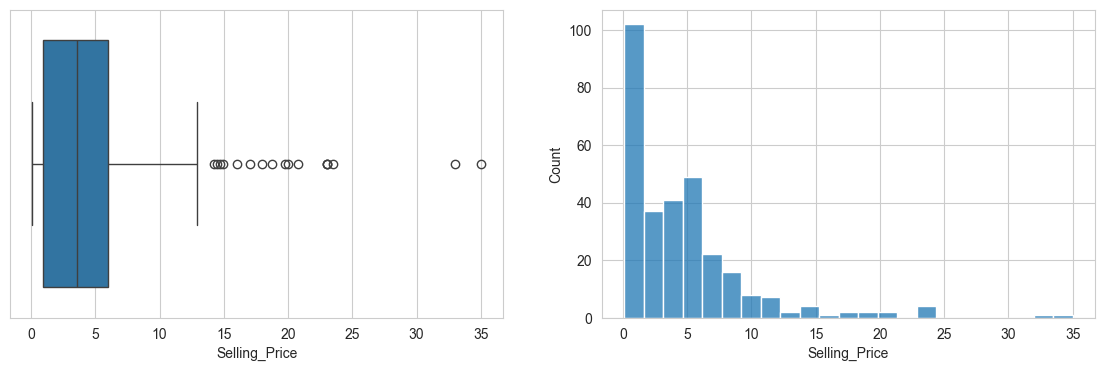

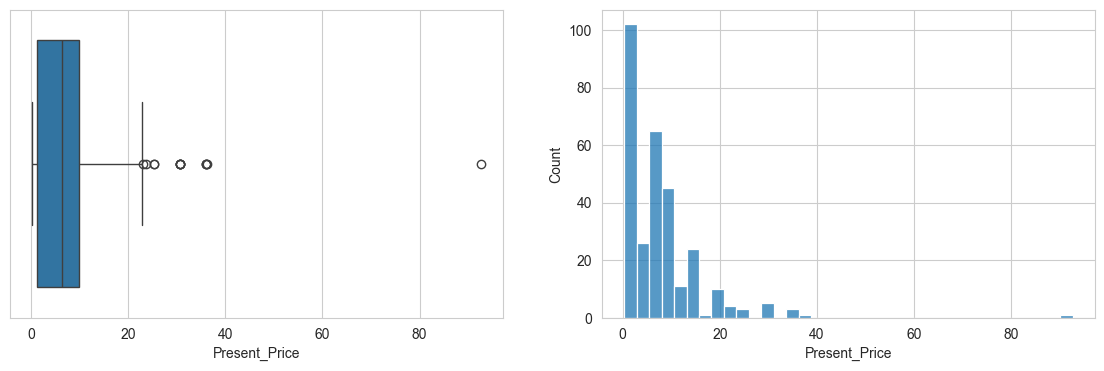

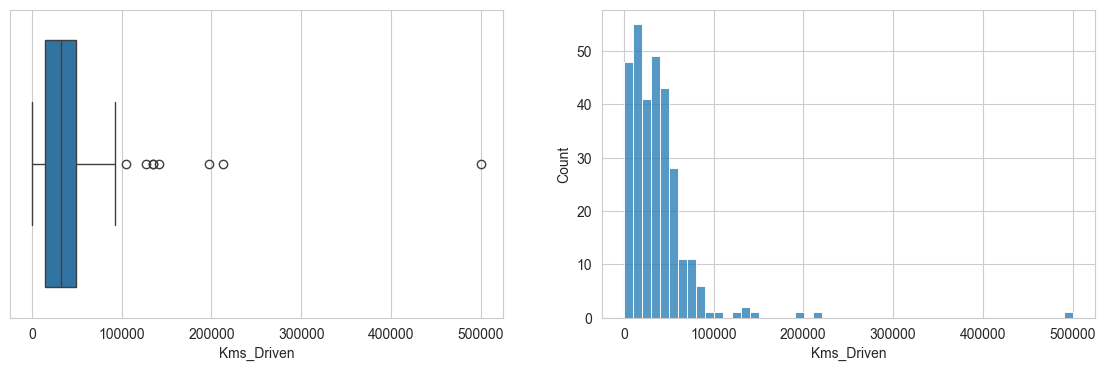

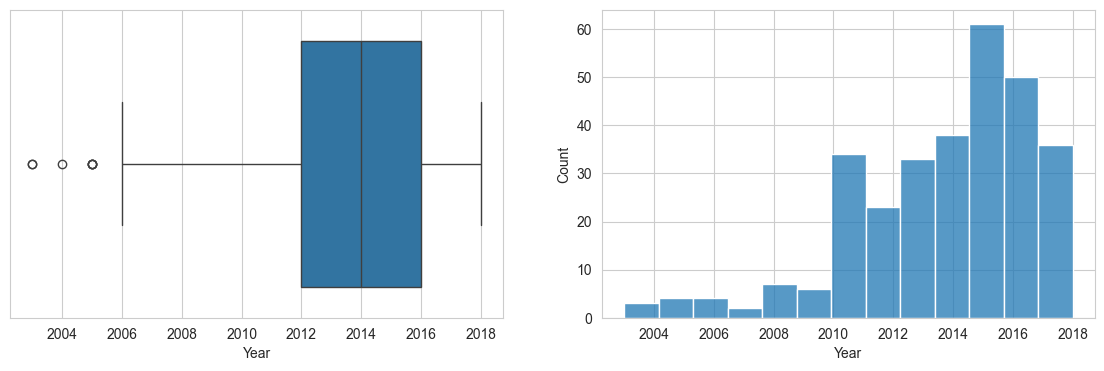

In [376]:
for nvar in numeric_vars:
    box_hist_plot(nvar)

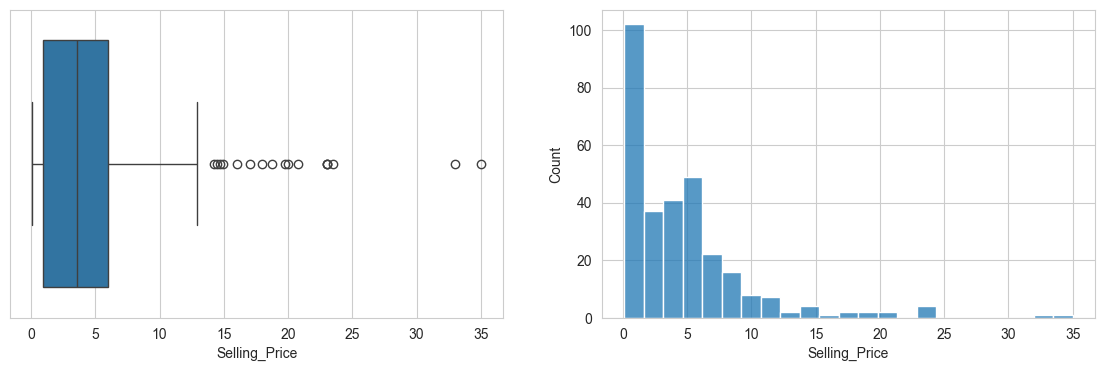

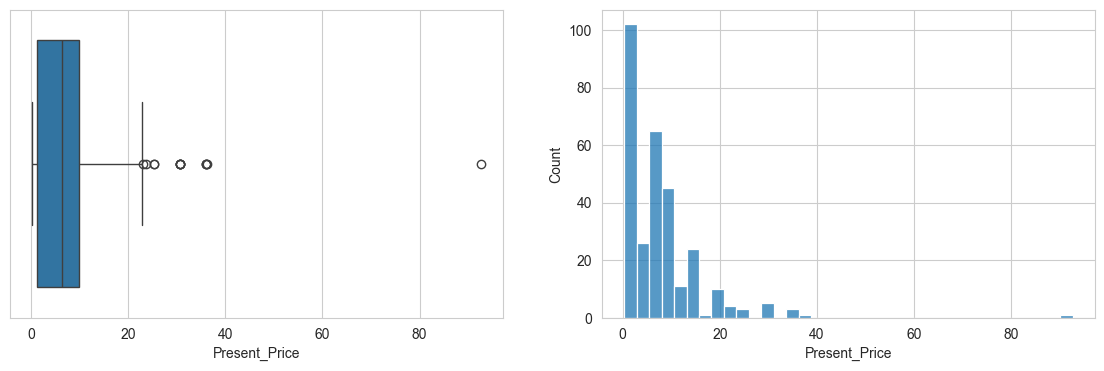

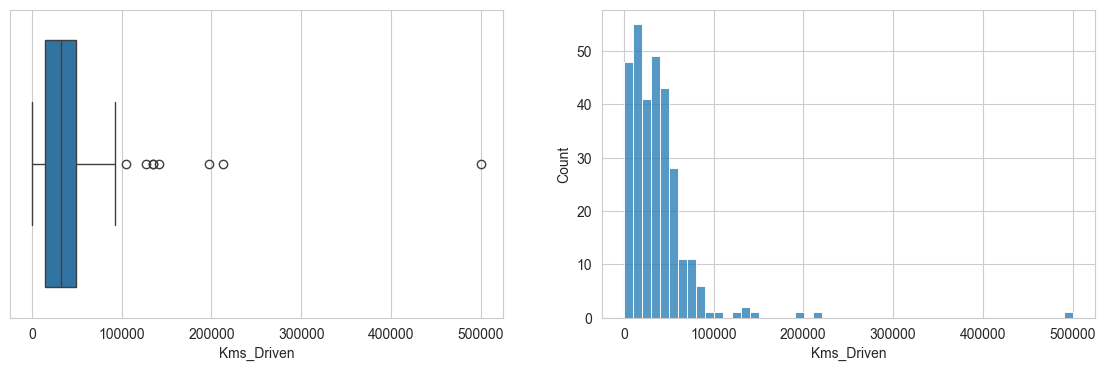

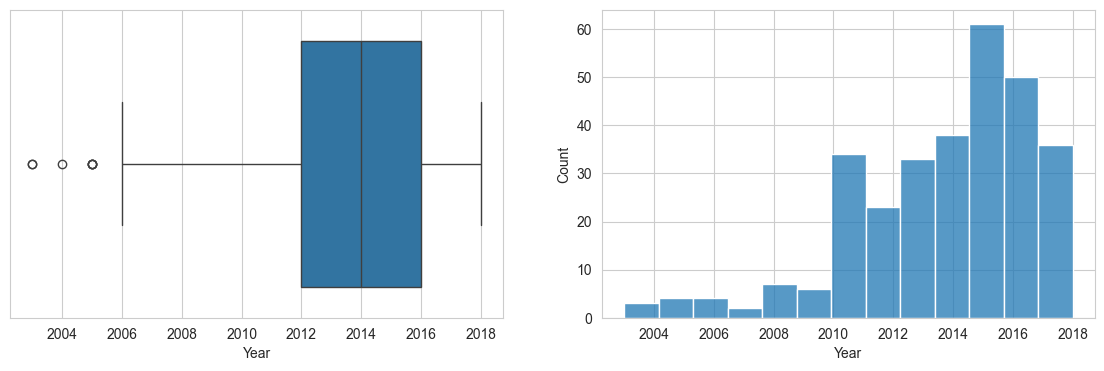

In [377]:
# Approach Two
numeric_vars = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Year']

for nvar in numeric_vars: 
    fig, axes = subplots(1, 2, figsize=(14, 4))
    sns.boxplot(x=df[nvar], ax=axes[0]);
    sns.histplot(x=df[nvar], ax=axes[1]);
    plt.show()

### Selling_Price

The distribution of Selling_Price is clearly non-normal and right-skewed, with a long tail extending toward higher prices. This indicates that while most cars are sold at relatively lower prices, a smaller number of vehicles are sold at much higher prices.

This observation is supported by the corresponding boxplot, which shows numerous outliers beyond the upper whisker. Most observations are concentrated roughly between 0 and 5 (lakhs), while several extreme values lie far above this range.

Additionally, the histogram exhibits a sharp starting and central peak combined with heavy tails, which indicates a leptokurtic distribution (high kurtosis). This suggests that extreme selling prices occur more frequently than would be expected under a normal distribution, a common characteristic of real-world price data.

### Selling_Price

The distribution of Selling_Price is clearly non-normal and right-skewed, with a long tail extending toward higher prices. This indicates that while most cars are sold at relatively lower prices, a smaller number of vehicles are sold at much higher prices.

This observation is supported by the corresponding boxplot, which shows numerous outliers beyond the upper whisker. Most observations are concentrated roughly between 0 and 5 (lakhs), while several extreme values lie far above this range.

Additionally, the histogram exhibits a sharp central peak combined with heavy tails, which indicates a leptokurtic distribution (high kurtosis). This suggests that extreme selling prices occur more frequently than would be expected under a normal distribution, a common characteristic of real-world price data.

### Kms_Driven

The distribution of Kms_Driven is strongly right-skewed, with a very long and heavy tail extending toward higher mileage values. This indicates that most cars have been driven a moderate number of kilometers, while a smaller subset of vehicles has exceptionally high mileage.

The histogram shows a high starting and central peak along with heavy tails, and the boxplot reveals several extreme outliers. Together, these features indicate a leptokurtic distribution, meaning that extreme mileage values occur relatively frequently.

From a practical perspective, this reflects real-world usage patterns, where a few heavily driven vehicles coexist with a majority of moderately used cars.

### Kms_Driven

The distribution of Kms_Driven is strongly right-skewed, with a very long and heavy tail extending toward higher mileage values. This indicates that most cars have been driven a moderate number of kilometers, while a smaller subset of vehicles has exceptionally high mileage.

The histogram shows a high central peak along with heavy tails, and the boxplot reveals several extreme outliers. Together, these features indicate a leptokurtic distribution, meaning that extreme mileage values occur relatively frequently.

From a practical perspective, this reflects real-world usage patterns, where a few heavily driven vehicles coexist with a majority of moderately used cars.

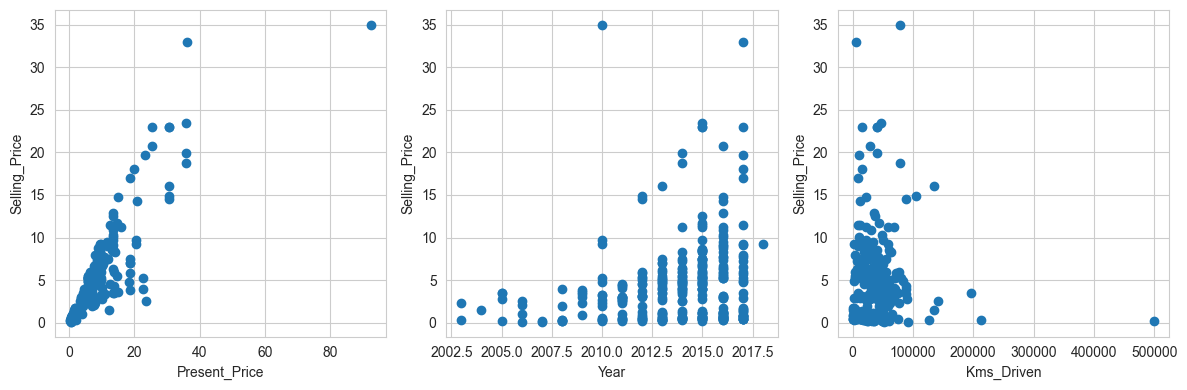

In [378]:
columns = ['Present_Price', 'Year', 'Kms_Driven']
fig, axes = subplots(1, 3, figsize=(12, 4))
for i in range(len(columns)):
    axes[i].scatter(df[columns[i]], df['Selling_Price'])
    axes[i].set_xlabel(columns[i])
    axes[i].set_ylabel('Selling_Price')
plt.tight_layout()
plt.show()

### Scatter Plots(Selling_Price vs numeric variables)
#### Selling_Price vs Present_Price
- There is a strong positive and roughly linear relationship between Present_Price and Selling_Price. As the present market price of a car increases, its selling price also tends to increase. Some outliers are present at highr price values which likely indicate the existence of luxury or premium cars, less depreciation or special market behavior.

#### Selling_Price vs Year
- This scatter plot shows a roughly linear relationship between feature "Year"(the year that a car was made) and Selling_Price. There is a strong positive relationship, as the year inceases, that is, the cars are newer, selling price also increases. There is also some outliers showing some newer cars with very high selling price.

#### Selling_Price vs Kms_Driven
- The scatter plot shows a clear negative relationship between kilometers driven and selling price of a car. As mileage increases the selling price generally decreases, indicating depreciation. The relationship appears to be non-linear with a steeper decline at lower mileage values. A few outliers are present, including cars with high mileage but relatively high selling price.

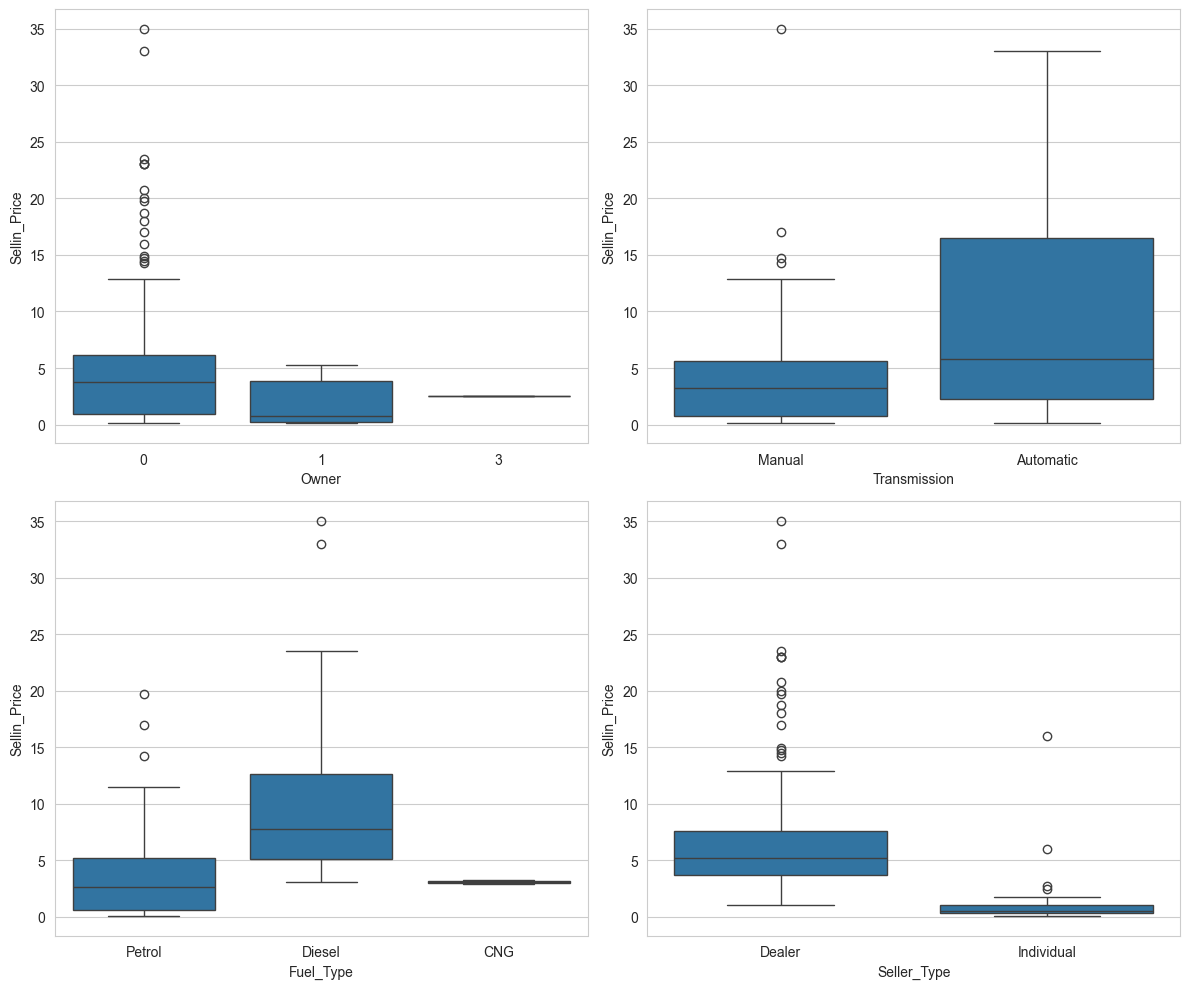

In [379]:
columns = ['Owner', 'Transmission', 'Fuel_Type', 'Seller_Type']
fig, axes = subplots(2, 2, figsize=(12, 10))
for i in range(len(columns)):
        ax = axes[i//2, i%2]
        sns.boxplot(x=df[columns[i]], y=df['Selling_Price'], ax=ax)
        ax.set_xlabel(columns[i])
        ax.set_ylabel('Sellin_Price')
plt.tight_layout()
plt.show()

### Box Plots (categorical variables)
#### Owner
 - Our boxplot shows that median selling price decreases as the number of previous ownerss increases, suggesting that the ownership history negatively affects car resale value.
#### Transmission
 - The boxplot shows that automatic cars have slightly higher median selling price than manual cars, although there is considerable overlap between the two group. Manual cars exibit several high-price outliers, indicating that while manual transmission cars are cheaper, a few are sold at unusually high prices.
#### Fuel_Type
 - Fuel type shows a clear relationship with selling price. Diesel vehicles have a higher median selling price compared to petrol and CNG vehicles. Diesel cars also exhibit the largest spread, indicating substantial variability in their prices. CNG vehicles show a very narrow spread, suggesting limited price variation, likely due to fewer observations. Outliers are present for both petrol and diesel vehicles, indicating a small number of high-priced cars within these fuel categories.
#### Seller_Type
- The boxplot shows that cars sold by dealers have a substantially higher median selling price compared to those sold by individuals. The interquartile ranges show minimal overlap, indicating a clear difference in typical prices. Outliers are present in both groups, particularly among dealer listings, suggesting the presence of high-end vehicles. Overall, Seller_Type appears to have a strong influence on selling price.

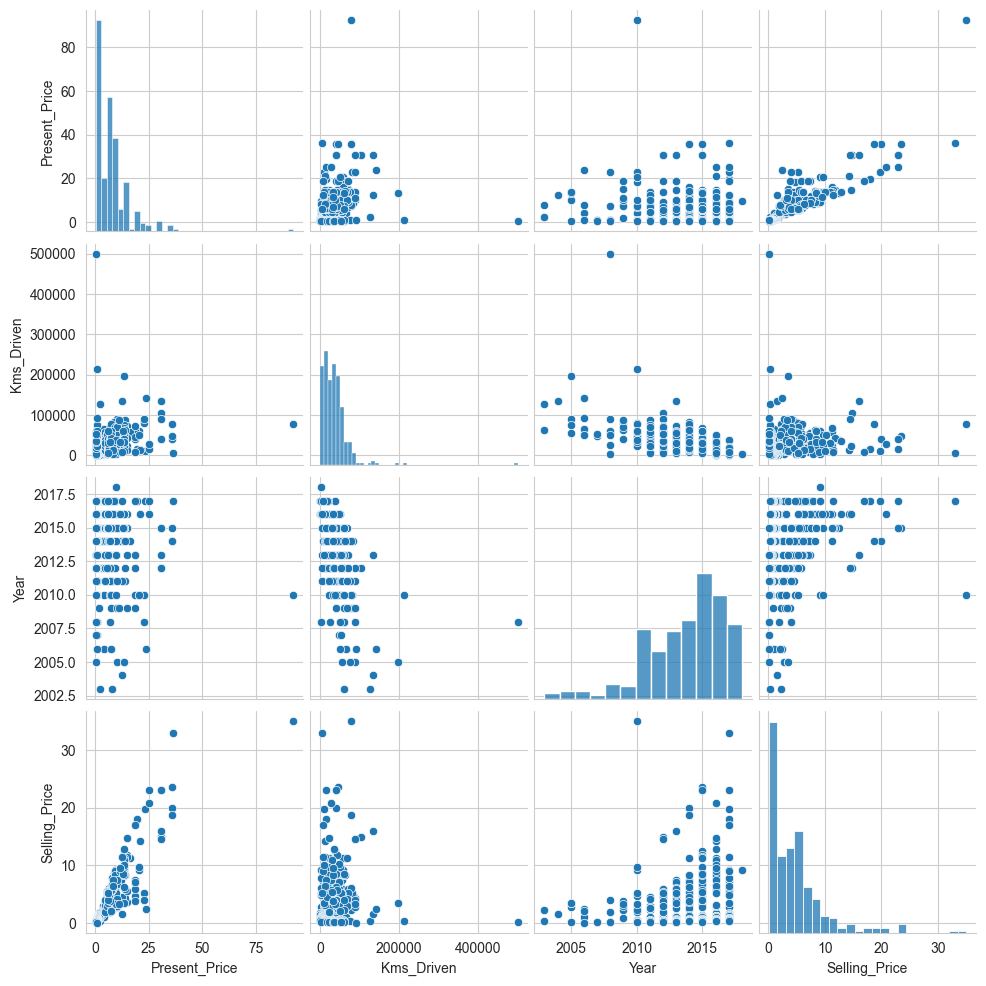

In [380]:
sns.pairplot(df[['Present_Price', 'Kms_Driven', 'Year', 'Selling_Price']])
plt.show()

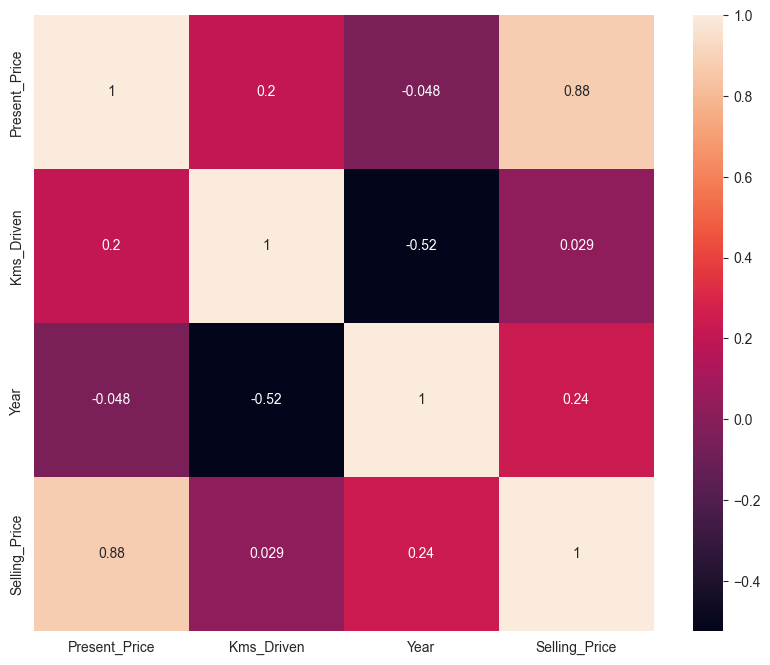

In [381]:
data = df[['Present_Price', 'Kms_Driven', 'Year', 'Selling_Price']]
plt.figure(figsize=(10, 8))
sns.heatmap(data=data.corr(), annot=True)
plt.show()

This hitmap shows the strongest positive correlation is between Present_Price and Selling_Price. It confirms that cars with higher current market value sell for more. Year shows moderate positive correlation. Newer cars tend to sell at higher prices Kms_Driven indicates negative correlation. Cars driven more tend to sell for less

## Data Preparation

##### The goal of the data preparation phase is to transform the raw car dataset into a clean, numerical and well-structured format suitable for regression modeling.

In [382]:
new_df = df.drop('Car_Name', axis=1)
new_df

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [383]:
df_model = new_df.copy()

In [384]:
df_model['Transmission'] = df_model['Transmission'].map({'Manual': 0, 'Automatic': 1})

In [385]:
df_model['Seller_Type'] = df_model['Seller_Type'].str.strip()

In [386]:
df_model['Seller_Type'] = df_model['Seller_Type'].str.title()

In [387]:
df_model['Seller_Type'] = df_model['Seller_Type'].map({'Dealer': 0, 'Individual': 1})
df_model

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,0,0,0
1,2013,4.75,9.54,43000,Diesel,0,0,0
2,2017,7.25,9.85,6900,Petrol,0,0,0
3,2011,2.85,4.15,5200,Petrol,0,0,0
4,2014,4.60,6.87,42450,Diesel,0,0,0
...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,Diesel,0,0,0
297,2015,4.00,5.90,60000,Petrol,0,0,0
298,2009,3.35,11.00,87934,Petrol,0,0,0
299,2017,11.50,12.50,9000,Diesel,0,0,0


In [388]:
df_model.dtypes

Year               int64
Selling_Price    float64
Present_Price    float64
Kms_Driven         int64
Fuel_Type         object
Seller_Type        int64
Transmission       int64
Owner              int64
dtype: object

In [389]:
df_model['Fuel_Type'].unique()

array(['Petrol', 'Diesel', 'CNG'], dtype=object)

In [390]:
dummies = pd.get_dummies(df_model['Fuel_Type'], prefix='Fuel_Type')

In [391]:
dummies = dummies.drop('Fuel_Type_Petrol', axis=1)

In [392]:
df_model = pd.concat([df_model, dummies], axis=1)

In [393]:
df_model = df_model.drop('Fuel_Type', axis=1)

In [394]:
df_model.columns

Index(['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Seller_Type',
       'Transmission', 'Owner', 'Fuel_Type_CNG', 'Fuel_Type_Diesel'],
      dtype='object')

In [395]:
df_model.dtypes

Year                  int64
Selling_Price       float64
Present_Price       float64
Kms_Driven            int64
Seller_Type           int64
Transmission          int64
Owner                 int64
Fuel_Type_CNG          bool
Fuel_Type_Diesel       bool
dtype: object

In [396]:
df_model.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Seller_Type,Transmission,Owner,Fuel_Type_CNG,Fuel_Type_Diesel
0,2014,3.35,5.59,27000,0,0,0,False,False
1,2013,4.75,9.54,43000,0,0,0,False,True
2,2017,7.25,9.85,6900,0,0,0,False,False
3,2011,2.85,4.15,5200,0,0,0,False,False
4,2014,4.60,6.87,42450,0,0,0,False,True


In [397]:
df_model['Fuel_Type_CNG'] = df_model['Fuel_Type_CNG'].astype(int)

In [398]:
df_model['Fuel_Type_Diesel'] = df_model['Fuel_Type_Diesel'].astype(int)

In [399]:
df_model.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Seller_Type,Transmission,Owner,Fuel_Type_CNG,Fuel_Type_Diesel
0,2014,3.35,5.59,27000,0,0,0,0,0
1,2013,4.75,9.54,43000,0,0,0,0,1
2,2017,7.25,9.85,6900,0,0,0,0,0
3,2011,2.85,4.15,5200,0,0,0,0,0
4,2014,4.60,6.87,42450,0,0,0,0,1


## Modeling

In this phase, we build a predictive model to estimate the Selling_Price of a used car based on its characteristics. Given that the target variable(Selling_Price) is continues and the relationship between the predictors and the target appear approximatly linear, multiple linear regression is chosen as the initial modeling technique. 

#### The objectives of this phase are:

- To quantify the relationship between each predictor and the selling price.
- To understand how variables such as car age, mileage, fuel type and current market price influence resale value.
- To evaluate the model's performance using appropriate statistical measures.

#### The prepared dataset is divided into:

- X: The feature matrix containing all explanatory variables
- y: The target variable (Selling_Price)

This model will serve as a baseline, and its results will later be assessed and potentially improved through diagnosticts and refinements.

In [400]:
y = df_model['Selling_Price']
X = df_model.drop('Selling_Price', axis=1)
X

,Year,Present_Price,Kms_Driven,Seller_Type,Transmission,Owner,Fuel_Type_CNG,Fuel_Type_Diesel
0,2014,5.59,27000,0,0,0,0,0
1,2013,9.54,43000,0,0,0,0,1
2,2017,9.85,6900,0,0,0,0,0
3,2011,4.15,5200,0,0,0,0,0
4,2014,6.87,42450,0,0,0,0,1
...,...,...,...,...,...,...,...,...
296,2016,11.60,33988,0,0,0,0,1
297,2015,5.90,60000,0,0,0,0,0
298,2009,11.00,87934,0,0,0,0,0
299,2017,12.50,9000,0,0,0,0,1


In [401]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)

### Data Transformation
<br>
The purpose of this section is to prepare the numerical features for modeling by addressing differences in scale, skewness, and the presence of outliers. In this dataset, numerical variables span very different ranges—for example, Present_Price ranges roughly from 0 to 35, while Kms_Driven ranges from near 0 to over 100,000. Without proper scaling, variables with larger magnitudes (such as Kms_Driven) can disproportionately influence the model, leading to biased coefficient estimates and unstable training.
<br>
The purpose of this section is to prepare the numerical features for modeling by addressing differences in scale, skewness, and the presence of outliers. In this dataset, numerical variables span very different ranges—for example, Present_Price ranges roughly from 0 to 35, while Kms_Driven ranges from near 0 to over 100,000. Without proper scaling, variables with larger magnitudes (such as Kms_Driven) can disproportionately influence the model, leading to biased coefficient estimates and unstable training.
<br>
To address this issue, feature scaling is applied. Given the presence of outliers in several numerical variables, the RobustScaler is used, as it scales features based on the median and interquartile range (IQR), making it less sensitive to extreme values compared to standard normalization techniques.
<br>
To avoid data leakage, all transformations that learn parameters from the data are fitted only on the training set and then applied to both the training and test sets. The transformation workflow is as follows:

1. Split the data into training and test sets

2. Apply log or power transformations (using training data logic)

3. Fit the scaler on the transformed training data

4. Transform both the training and test sets using the fitted scaler

5. Train the regression model

This structured approach ensures that the evaluation reflects realistic model performance on unseen data.

Based on the exploratory data analysis, Selling_Price and Kms_Driven exhibit strong right skewness and heavy tails. To mitigate the influence of extreme values and improve linear relationships, a logarithmic transformation is applied to Kms_Driven. Log-transforming the target variable (Selling_Price) is considered but applied only if it improves residual behavior, as it changes the interpretation of model coefficients.

In [402]:
X_train = X_train.copy()
X_test = X_test.copy()

X_train['Kms_Driven'] = np.log1p(X_train['Kms_Driven'])
X_test['Kms_Driven'] = np.log1p(X_test['Kms_Driven'])

In [403]:
numeric_features = ['Year', 'Present_Price', 'Kms_Driven']

scaler = RobustScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

In [404]:
model = LinearRegression()

In [405]:
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [406]:
y_pred = model.predict(X_test)

In [407]:
print("R2 score:", r2_score(y_test, y_pred))

R2 score: -369252.9370294065


In [408]:
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef:.4}")

Year: 1.435
Present_Price: 3.59
Kms_Driven: -0.2448
Seller_Type: -1.287
Transmission: 1.505
Owner: -0.8878
Fuel_Type_CNG: -0.7057
Fuel_Type_Diesel: 1.795


### Coefficients Interpretation

#### Year: +0.3538
- Each additional year(newer car), increases selling price by ~0.35 units, holding everythin else constant.

#### Present_Price +0.4292
- For every 1-unit increase in present market price, selling price increases by 0.42 units.

#### Kms_Driven: -0.000006157
- For eacch edditional kilometer driven, selling price decreases slightly(~0.000006).

#### Seller_Type: -1.191
- Dealer = 0 (Baseline)
- individual = 1
- Cars sold by individuals are priced ~1.91 units lower than dealer-sold cars.

#### Transmission: +1.639
- manual = 0 (Baseline)
- Automatic = 1
- Automatic cars sell for ~1.639 units more than manual cars.

#### Owner: -0.9038
- Each additional previous owner reduces price by ~0.90 units.

#### Fuel_Type (reference=Petrol)
##### Fuel_Type_CNG: -0.7385
- Fuel_Type_CNG: -0.739
##### Fuel_Type_Diesel: +1.795
- Diesel cars sell for ~1.80 units more than petrol cars.

#### Diesel has the largest positive categorical effect.

### Modeling Summery
- A multiple linear regression model was trained to predict used cars selling prices using vehicle attributes and categorical encodings. The model achieved an R2 score of approximately 0.85 on the test set, indicating strong explanatory power. Present market price, Fuel type(Diesel), transmission type, seller type and vehicle age were identified as key predictors. Mileage and number of previous owners negatively affected price. consistent with domain expectations(common-sense beliefs about cars).

## Model Evaluation

In this phase, we evaluate the predictive performance of the linear regression model using error-based metrics. while R2 measures explained variance, MAE, MSE and RMSE quantify the magnitude of prediction errors in actual price units, providing a more practical assessment of model performance.

In [409]:
mse = mean_squared_error(y_test, y_pred)

In [410]:
rmse = np.sqrt(mse)

In [411]:
mae = mean_absolute_error(y_test, y_pred)

In [412]:
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

MSE: 8505980.2759
RMSE: 2916.5014
MAE: 2916.4174


### Interpretation

The model achieves a strong predictive performance with an R² score of approximately 0.85, indicating that most of the variability in selling price is explained by the predictors. The Mean Absolute Error (MAE) of about 1.22 suggests that, on average, the model’s predictions deviate from the true selling price by a relatively small amount. The higher RMSE value compared to MAE indicates the presence of some larger prediction errors, which is expected in real-world used-car pricing due to variability in car condition and market factors.

### Residual Analysis

After fitting a linear regression model, it is important to check whether the model assumptions are reasonably satisfied. One of the most informative diagnostic tools is the residuals vs fitted values plot.

Residuals are defined as:

### Residual= y true − y predicted


This plot helps us assess several key assumptions of linear regression:

1. Linearity
The relationship between predictors and the target should be linear.
If the model is appropriate, residuals should be randomly scattered around zero with no clear pattern.

2. Homoscedasticity (Constant Variance)
The spread of residuals should be roughly constant across all predicted values.
A funnel or cone shape indicates heteroscedasticity.

3. Model Misspecification
A visible curve or systematic structure suggests that important nonlinear relationships or interactions may be missing from the model.

5. Outliers
Points with unusually large residuals may indicate outliers that could disproportionately influence the model.

In [413]:
residuals = y_test - y_pred

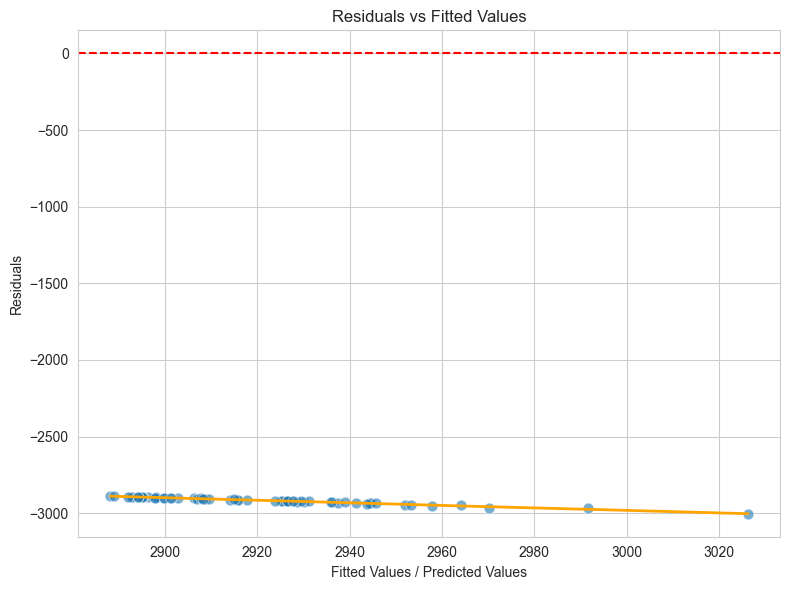

In [414]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor='w', s=60)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
sns.regplot(x=y_pred, y=residuals, scatter=False, lowess=True, line_kws={'color': 'orange', 'lw': 2})
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values / Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

We experimented with log-transforming the target variable to address skewness.
However, this resulted in degraded predictive performance and stronger residual patterns.
<br>
This suggests that the original scale of Selling_Price is already well-suited for linear modeling.
<br>
Therefore, the final model retains Selling_Price in its original scale and applies transformations only to skewed predictors.